<a href="https://colab.research.google.com/github/aditijoshi613/Machine-Learning-For-Remote-Sensing/blob/main/ML_For_Remote_Sensing_Kaggle_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import tensorflow module. Check API version.
import tensorflow as tf
import numpy as np

print (tf.__version__)

# required for TF to run within docker using GPU (ignore otherwise)
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

2.3.0


In [ ]:
from google.colab import drive   #wget! is also an option to directly access from github
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pwd

'/content/drive/My Drive/SHALA : ML Module'

In [ ]:
%cd drive

[Errno 2] No such file or directory: 'drive'
/content/drive/My Drive/SHALA : ML Module


In [ ]:
%cd 'My Drive'

[Errno 2] No such file or directory: 'My Drive'
/content/drive/My Drive/SHALA : ML Module


In [ ]:
%cd 'SHALA : ML Module'
# %ls

[Errno 2] No such file or directory: 'SHALA : ML Module'
/content/drive/My Drive/SHALA : ML Module


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# define training data augmentation pipeline
batch_size = 16
train_datagen = ImageDataGenerator(rescale = 1.0/255.,
      #data_format =  "channels_last",
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,#vertical_flip = True,
      fill_mode='nearest',validation_split=0.2)

# load training data
TRAINING_DIR = 'train/train'
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    target_size=(256, 256),color_mode="rgb",
                                                    batch_size= batch_size,
                                                    class_mode='categorical',
                                                    shuffle = True,
                                                    subset = 'training')

validation_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    target_size=(256, 256),color_mode="rgb",
                                                    batch_size= batch_size,
                                                    class_mode='categorical',shuffle = True,subset='validation') # set as validation data
test_datagen = ImageDataGenerator( rescale = 1.0/255.,
      #data_format =  "channels_last",
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,#vertical_flip = True,
      fill_mode='nearest',validation_split=0.2)
TEST_DIR = 'test_set'
test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                    batch_size=batch_size,
                                                    class_mode=None,color_mode="rgb",
                                                    target_size=(256, 256), shuffle = False)
print(train_generator.class_indices)

Found 448 images belonging to 7 classes.
Found 112 images belonging to 7 classes.
Found 95 images belonging to 1 classes.
{'0-basketball court': 0, '1-beach': 1, '2-forest': 2, '3-railway': 3, '4-tennis_court': 4, '5-swimming_pool': 5, '6-others': 6}


In [ ]:


from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, Dense, BatchNormalization, Dropout, Flatten, concatenate
input = Input(shape=(256,256,3))
l11 = Conv2D(16, (1,1),padding='same', activation='relu', kernel_initializer='HeNormal', bias_initializer='zeros')(input)
l111 =  Conv2D(16, (5,5), padding='same',activation='relu', kernel_initializer='HeNormal', bias_initializer='zeros')(l11)
l11_ = BatchNormalization()(l111)

l12 = Conv2D(16, (1,1),padding='same', activation='relu', kernel_initializer='HeNormal', bias_initializer='zeros')(input)
l122 = Conv2D(16, (3,3),padding='same', activation='relu',kernel_initializer='HeNormal', bias_initializer='zeros')(l12) 
l12_ = BatchNormalization()(l122)

l13 = MaxPooling2D(pool_size=(3, 3),padding='same',strides = (1,1))(input)
l13__ = Conv2D(16, (1,1), activation='relu',padding='same', kernel_initializer='HeNormal', bias_initializer='zeros')(l13)
l13_ = BatchNormalization()(l13__)
l1 = concatenate([l11_,l12_,l13_], axis=3)
# l222 = Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3),kernel_initializer='HeNormal', bias_initializer='zeros')(l1)
# l22 = BatchNormalization()(l222)
# l2 = MaxPooling2D(pool_size=(2, 2))(l22)
# l333 = Conv2D(64,(1,1),activation='relu', input_shape=(256, 256, 3),kernel_initializer='HeNormal', bias_initializer='zeros')(l2)
# l33 = BatchNormalization()(l333)
# l3 = MaxPooling2D(pool_size=(2, 2))(l33)
l4 = Flatten()(l1)
#l5 = Dense(16, activation='relu',kernel_initializer='HeNormal', bias_initializer='zeros')(l4)
#l6 = Dropout(0.5, seed = 0)(l5)
output = Dense(7, activation='softmax')(l4)
from keras.models import Model#
model =  Model(inputs = input, outputs = output )
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.000001),
        loss="categorical_crossentropy",
         metrics=["accuracy"])

# print model summary
model.summary()





Model: "functional_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_238 (Conv2D)             (None, 256, 256, 16) 64          input_31[0][0]                   
__________________________________________________________________________________________________
conv2d_240 (Conv2D)             (None, 256, 256, 16) 64          input_31[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_129 (MaxPooling2D (None, 256, 256, 3)  0           input_31[0][0]                   
______________________________________________________________________________________

In [ ]:
#model fitting 
# define callback function for training termination criteria
accuracy_cutoff = 0.99
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if(logs.get('accuracy') > 0.90):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

# initialize training config
epochs = 100 #less no. for hyperparameter tuning

# run training
print("[INFO] training...")
history = model.fit(train_generator, validation_data=validation_generator,
                    epochs=epochs, verbose=1,callbacks=[myCallback()])
# model.fit(train_generator,validation_data=validation_generator,batch_size = batch_size,epochs = 6,verbose=1)

[INFO] training...
Epoch 1/100
28/28 [==============================] - 17s 614ms/step - loss: 1.3668 - accuracy: 0.5290 - val_loss: 2.0924 - val_accuracy: 0.1696
Epoch 2/100
28/28 [==============================] - 17s 598ms/step - loss: 1.0474 - accuracy: 0.6049 - val_loss: 1.8023 - val_accuracy: 0.2321
Epoch 3/100
28/28 [==============================] - 17s 597ms/step - loss: 0.9467 - accuracy: 0.6540 - val_loss: 1.6313 - val_accuracy: 0.3571
Epoch 4/100
28/28 [==============================] - 17s 598ms/step - loss: 0.8020 - accuracy: 0.6920 - val_loss: 1.5700 - val_accuracy: 0.4107
Epoch 5/100
28/28 [==============================] - 17s 602ms/step - loss: 0.7179 - accuracy: 0.7210 - val_loss: 1.4278 - val_accuracy: 0.5268
Epoch 6/100
28/28 [==============================] - 17s 598ms/step - loss: 0.7423 - accuracy: 0.7188 - val_loss: 1.2551 - val_accuracy: 0.5982
Epoch 7/100
28/28 [==============================] - 17s 597ms/step - loss: 0.7622 - accuracy: 0.7254 - val_loss: 1.2

Text(0.5, 1.0, 'Training and validation loss')

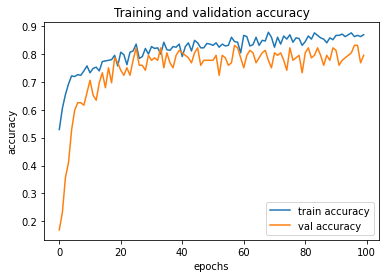

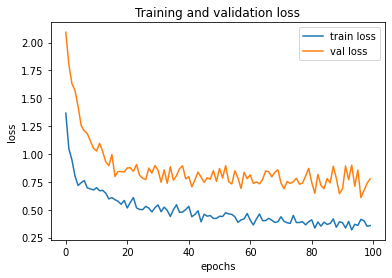

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# retrieve a list of list results on training and test data sets for each training epoch
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # get number of epochs

# plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc="lower right")
plt.title('Training and validation accuracy')
plt.figure()

# plot training and validation loss per epoch
plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc="upper right")
plt.title('Training and validation loss')

In [ ]:
predictt = model.predict(test_generator,verbose=1)

6/6 [==============================] - 2s 318ms/step


In [ ]:
predictions = np.argmax(predictt,axis=1) + 1

In [ ]:

imageid = test_generator.filenames
for i in range(len(imageid)):
  imageid[i] = str(imageid[i])
  imageid[i] = imageid[i].strip('test_set/')
  imageid[i] = imageid[i].strip('.jpg')
imageid = [int(x) for x in imageid]
# imageid

In [ ]:
import pandas as pd

result = pd.DataFrame({'ImageID':imageid,'Label':predictions})


In [ ]:
result.to_csv('180020010.csv',index=False)